# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-15 21:14:32.803757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 21:14:32.803884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 21:14:32.930459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/final-version/Stage 1/Stage 1'

In [3]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.8)]
    val_names = image_names[int(len(image_names)*0.8):int(len(image_names)*0.9)]
    test_names = image_names[int(len(image_names)*0.9):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

Found 6573 images belonging to 2 classes.
Found 821 images belonging to 2 classes.
Found 823 images belonging to 2 classes.


In [4]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

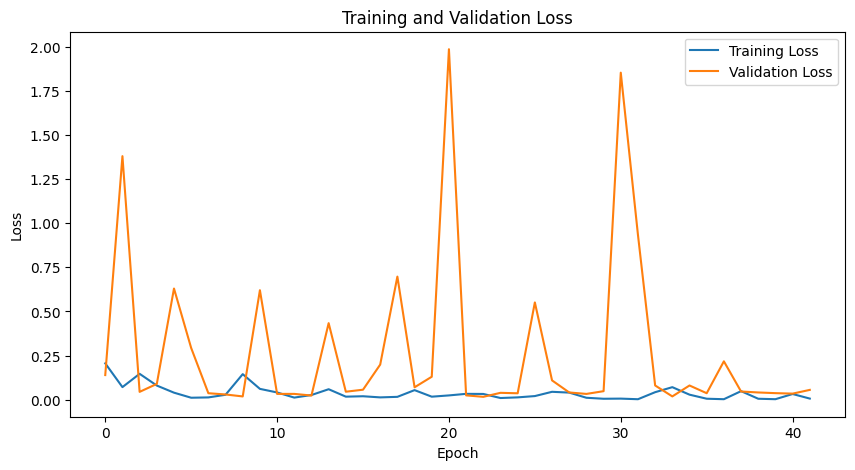

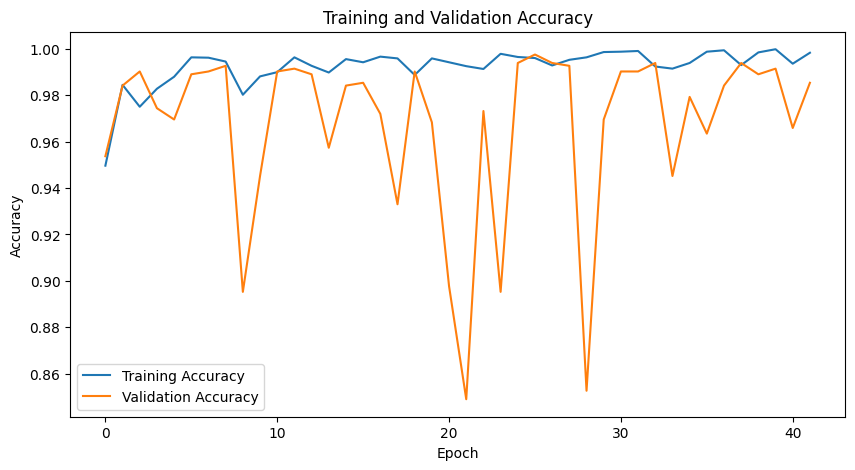

In [14]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [15]:
model.load_weights('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

 2/52 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 0.0028     

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9875 - loss: 0.0610


W0000 00:00:1715813314.334033     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.0604, Test Accuracy: 0.99%
